**Table of contents**<a id='toc0_'></a>    
- [Data Preprocessing](#toc1_1_)    
- [OPTIONAL: Keras tuner to get optimal layer and neuron](#toc2_)    
- [ML Modelling](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Data Preprocessing](#toc0_)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('clean_data.csv')

# Separate features and labels
X = data[['left_shoulder_y', 'left_shoulder_x', 'right_shoulder_y', 'right_shoulder_x', 'left_body_y', 'left_body_x', 'right_body_y', 'right_body_x', 'len_factor', 'left_knee_y', 'left_knee_x', 'right_knee_y', 'right_knee_x', 'left_foot_y', 'right_foot_y']]
y = data['fall'].astype(int)  # Convert boolean to int (1 for True, 0 for False)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Generated {len(X_train)} training samples and {len(X_test)} testing samples")

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Generated 109 training samples and 28 testing samples


# <a id='toc2_'></a>[OPTIONAL: Keras tuner to get optimal layer and neuron](#toc0_)

In [ ]:
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.losses import BinaryCrossentropy
from keras._tf_keras.keras.callbacks import ReduceLROnPlateau
from keras_tuner import HyperModel, RandomSearch

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=16, max_value=64, step=16),
                        activation='relu', input_shape=(X_train.shape[1],)))
        
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=8, max_value=32, step=8),
                            activation='relu'))
        
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001)
        return model

tuner = RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=50,
    executions_per_trial=2,
    directory='keras_tuner',
    project_name='fall_detection'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

In [ ]:
best_model.summary()

Best Model
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

# <a id='toc3_'></a>[ML Modelling](#toc0_)

In [2]:
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense, Dropout
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.losses import BinaryCrossentropy
from keras._tf_keras.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras._tf_keras.keras.metrics import AUC


model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=BinaryCrossentropy(), 
    metrics=['accuracy', AUC(name='auc')])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001, restore_best_weights=True, verbose=1)
model.summary()

/Users/adam/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
history = model.fit(
    X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stop]
)
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4332 - auc: 0.4081 - loss: 0.7443 - val_accuracy: 0.4545 - val_auc: 0.3036 - val_loss: 0.7078 - learning_rate: 0.0010
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5960 - auc: 0.6241 - loss: 0.6811 - val_accuracy: 0.3636 - val_auc: 0.3795 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4624 - auc: 0.4812 - loss: 0.7116 - val_accuracy: 0.4545 - val_auc: 0.4598 - val_loss: 0.6822 - learning_rate: 0.0010
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5838 - auc: 0.6207 - loss: 0.6788 - val_accuracy: 0.5909 - val_auc: 0.5982 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5707 - auc: 0.5853 - loss: 0.6864 - val_accuracy: 0.6364 - val_auc: 0.6607 - val_loss: 0.6574 - learning_rate: 0.0010
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5086 - auc: 0.5343 - loss:

In [4]:
model.save('fall_detection_model.keras')

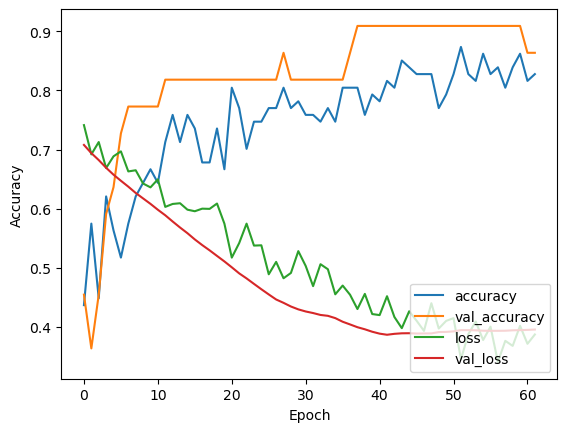

In [4]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Predicting 28 test samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


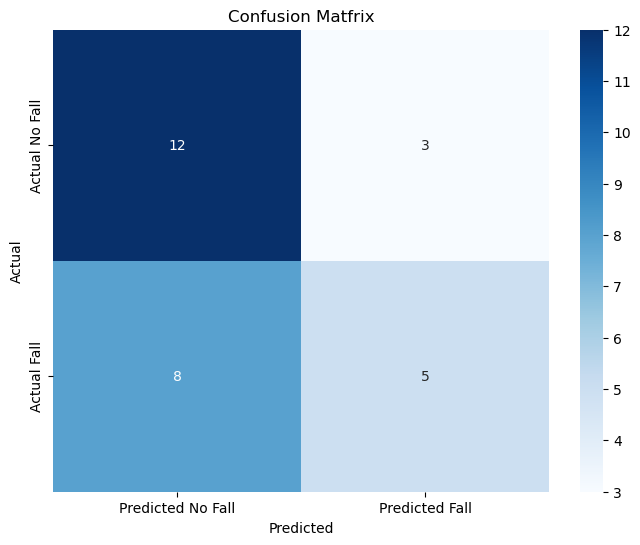

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Test model
print(f"Predicting {len(X_test)} test samples")
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

# Compute and visualizethe confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Fall', 'Predicted Fall'], yticklabels=['Actual No Fall', 'Actual Fall'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matfrix')
plt.show()